# import tools

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import csv 

# Set your dataset directory

In [2]:
sdir = r'D:\Afi\PROJEK\Semester 5\Web_Aplication_Hama_Detection\Dataset'

# Load file paths and labels

In [3]:
filepaths, labels = [], []
classlist = os.listdir(sdir)
for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print (classlist)


['hama_belalang', 'hama_ulat', 'sawi_sehat']


# Split the dataset

In [4]:
train_split, test_split = 0.7, 0.3
train_df, test_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)

# Set image parameters

In [5]:
height, width, channels = 224, 224, 3
batch_size = 16
img_size = (height, width)
img_shape = (height, width, channels)

# Data generators

In [6]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]
)

train_gen = datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 817 validated image filenames belonging to 3 classes.
Found 351 validated image filenames belonging to 3 classes.


# Build the model

In [7]:
model = keras.Sequential([
    # Feature Extraction
    layers.Conv2D(8, (3, 3), padding='same', input_shape=(img_shape), activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    # Fully Connected
    layers.Dense(1568, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
    
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

# Train and Test Data

In [8]:
epochs = 50

# Training without any callbacks
history = model.fit(x=train_gen, epochs=epochs, validation_data=test_gen)

# Save the model manually at the end of training
model.save('New_model2.h5')


Epoch 1/50
52/52 [==============================] - 72s 1s/step - loss: 0.8963 - accuracy: 0.5949 - val_loss: 0.8116 - val_accuracy: 0.6268
Epoch 2/50
52/52 [==============================] - 38s 723ms/step - loss: 0.7618 - accuracy: 0.6597 - val_loss: 0.7136 - val_accuracy: 0.6496
Epoch 3/50
52/52 [==============================] - 40s 771ms/step - loss: 0.6302 - accuracy: 0.7332 - val_loss: 0.5776 - val_accuracy: 0.7692
Epoch 4/50
52/52 [==============================] - 42s 815ms/step - loss: 0.6579 - accuracy: 0.7160 - val_loss: 0.7381 - val_accuracy: 0.4900
Epoch 5/50
52/52 [==============================] - 56s 1s/step - loss: 0.5762 - accuracy: 0.7540 - val_loss: 0.4716 - val_accuracy: 0.8034
Epoch 6/50
52/52 [==============================] - 51s 984ms/step - loss: 0.5120 - accuracy: 0.7870 - val_loss: 0.4816 - val_accuracy: 0.8148
Epoch 7/50
52/52 [==============================] - 58s 1s/step - loss: 0.5191 - accuracy: 0.7846 - val_loss: 0.4177 - val_accuracy: 0.8319
Epoch 8/

C:\Users\My Computer\.conda\envs\Belajar_env\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Print model performance

In [9]:
def print_model_performance(test_gen, print_code=0):
    preds = model.predict(test_gen)
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    errors = 0

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        if pred_index != true_index:
            errors += 1

    accuracy = (1 - errors / len(labels)) * 100
    print(f'Accuracy on the test set is {accuracy:.2f}%')

    if print_code != 0:
        for i in range(min(print_code, errors)):
            print(f'Filename: {file_names[i]}, Predicted Class: {pred_index[i]}, True Class: {true_index[i]}')

    y_true = np.array(labels)
    y_pred = np.argmax(preds, axis=1)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(class_dict.keys())))


print_model_performance(test_gen)

22/22 [==============================] - 8s 331ms/step
Accuracy on the test set is 78.06%
Classification Report:
               precision    recall  f1-score   support

hama_belalang       0.53      0.53      0.53        32
    hama_ulat       0.78      0.94      0.85       158
   sawi_sehat       0.85      0.67      0.75       161

     accuracy                           0.78       351
    macro avg       0.72      0.72      0.71       351
 weighted avg       0.79      0.78      0.78       351



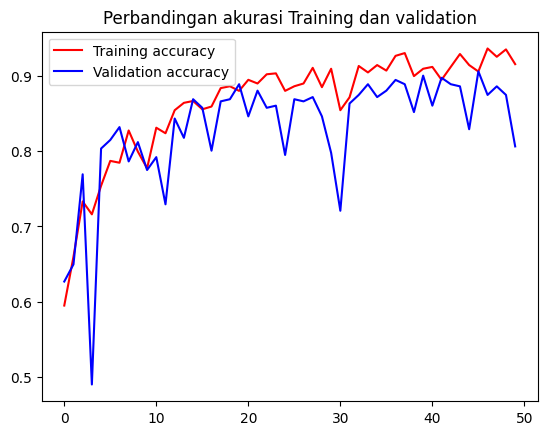

<Figure size 640x480 with 0 Axes>

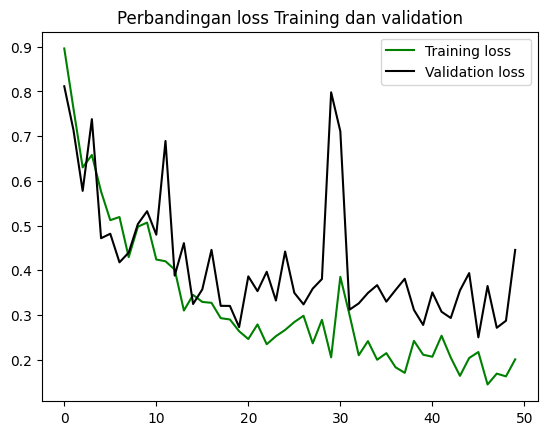

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Perbandingan akurasi Training dan validation')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'k', label='Validation loss')
plt.title('Perbandingan loss Training dan validation')
plt.legend(loc=0)
plt.figure()
plt.show()

In [11]:
print_code=0
preds=model.predict(test_gen) 
print_model_performance( test_gen,print_code )  

22/22 [==============================] - 7s 326ms/step
Accuracy on the test set is 79.49%
Classification Report:
               precision    recall  f1-score   support

hama_belalang       0.52      0.53      0.52        32
    hama_ulat       0.81      0.92      0.86       158
   sawi_sehat       0.85      0.72      0.78       161

     accuracy                           0.79       351
    macro avg       0.72      0.73      0.72       351
 weighted avg       0.80      0.79      0.79       351



In [14]:
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))

22/22 [==============================] - 8s 372ms/step
Confusion Matrix
[[ 22   2   8]
 [  4 149   5]
 [ 13  36 112]]


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

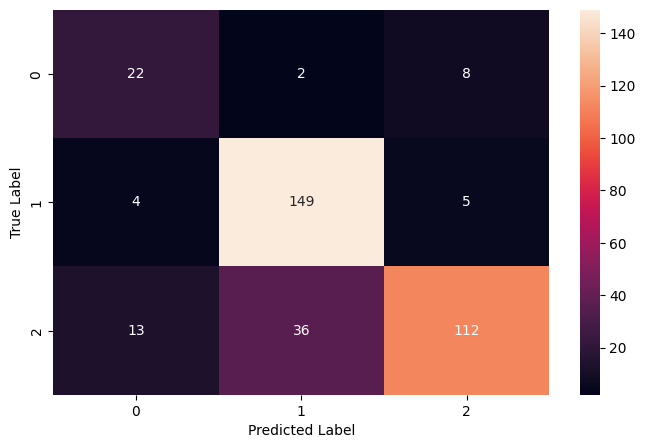

In [18]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(test_gen.classes, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("rue Label")
plt.show()